# 第１ステージ　微分を自動で求める

## ステップ1 箱としての変数

### 1.1変数とは<3>

In [4]:
import numpy as np
print(np.random.rand(2, 3))
print(np.random.rand(3, 2, 4))

[[0.1827968  0.76089911 0.39556724]
 [0.62511543 0.08684209 0.85573461]]
[[[0.16085822 0.97546544 0.05349926 0.80502328]
  [0.44719979 0.29444342 0.85033976 0.98343958]]

 [[0.24127922 0.90259853 0.66312175 0.10723939]
  [0.11918422 0.86439697 0.43932729 0.40385953]]

 [[0.54129778 0.76873314 0.69830649 0.0170433 ]
  [0.09966885 0.52498115 0.6235439  0.5374397 ]]]


### 1.2 variableクラス実装<4>

In [1]:
class Variable():
  def __init__(self, data):
    self.data = data

In [2]:
import numpy as np

data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


これ何がしたかったって、
xはあくまで箱であってデータそのものではないっていうことを強調したいだけ

あくまで箱でしかないから、データを変更するのも簡単だ

In [3]:
x.data = np.array(2.0)
print(x.data)

2.0


### 1.3 Numpyの多次元配列<6>

## ステップ２ 変数を生み出す関数<9>

### 2.1　関数とは<9>

### 2.2 Functionクラスの実装<10>

_call__メソッドを実装する。
内容はデータを取り出して２乗の計算を行う。

ちなみに__call__は特殊メソッドで、 

f= Function()としたとき、 f(...)と書くと__call__メソッドが呼び出される

In [4]:
class Function():
  def __call__(self, input):
    x = input.data
    y = x ** 2
    output = Variable(y)
    return output

inputってVariableのインスタンスが来る予定だからinput.dataで取り出すんだ！！

In [5]:
x = Variable(np.array(10))
f = Function()
y = f(x)

print(type(y))
print(y.data)

<class '__main__.Variable'>
100


以降の具体的な計算を行うclassは、Functionクラスを継承したものにしたいので、書き換える。

In [6]:
class Function():
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    return output

  def forward(self, x):
    raise NotImplementedError()

forwardをオーバーライドせずに使った場合errorを出す！

In [7]:
class Square(Function):
  def forward(self, x):
    return x ** 2

In [8]:
x = Variable(np.array(10))
f = Square()
y = f(x)

print(type(y))
print(y.data)

<class '__main__.Variable'>
100


## ステップ3 関数の連結<15>

まず指数関数を実装する

In [9]:
class Exp(Function):
  def forward(self, x):
    return np.exp(x)

合成関数$(e^{x^{2}})^2$っていうのを実装してみよう

In [10]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
c = C(b)
print(y.data)

100


## ステップ４　数値微分＜１９＞

中央差分近似で微分を定義していこう

In [11]:
def numerical_diff(f, x, eps=1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

$y=x^2$のx=2での微分係数

In [12]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy)

4.000000000004


合成関数$(e^{x^{2}})^2$の微分

In [13]:
def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)

3.2974426293330694


数値微分は簡単だけど、NNで全てのパラメータに対して適応するのは計算リソース的にやばい

→**BP法**

## ステップ５　BPの理論＜２５＞

## ステップ６　手作業によるBP法＜３１＞

Variableクラスを追加実装しておく

何を追加するって「逆伝播で微分が計算されたときにその値を保存しておく」要素

In [14]:
class Variable():
    def __init__(self, data):
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく

Functionクラスを追加実装

何を追加するって、「逆伝播の計算を実行するためのbackwardメソッド」と「inputのデータを記憶しておく」

In [15]:
class Function():
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        self.input = input
        output = Variable(y)
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

SquareとExpも追加実装

In [16]:
class Square(Function):
    def forward(self, x):
        y =  x ** 2
        return y
  
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx


class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y

    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

実際にここまでの逆伝播を動かしてみよう！

まず、順伝播を動かす

In [17]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

上のに対して逆伝播を動かす

In [18]:
y.grad = np.array(1.0) #最初はdy/dy=1
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


## ステップ7　BP法の自動化＜３7＞

ステップ６みたいな形だと全て自分で値を突っ込ませて計算させなくてはあかん

これは面倒なので、pythonにやらせよう

逆伝播を行うために関数と変数のつながりを記憶しておく必要がある

変数と関数のつながりを覚えておくことで、どの関数を微分してその中にどの変数を入れるかがわかる。
これによって逆伝播が可能となる

In [19]:
class Variable():
    def __init__(self, data):
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく
        self.creator = None #最初の段階では変数のcreatorは人間だから関数との関係は入れない。とりあえずNone

    def set_creator(self, func):
        self.creator = func

In [20]:
class Function():
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        output.set_creator(self) #出力変数が生みのfunctionを記憶している。多分このselfっていうのがそのままcallされたfuctionすなわち生みの関数だと思うだな
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

assertを使ってここまでの処理が実際に計算グラフを満たしているのか確認していこう

In [21]:
class Square(Function):
    def forward(self, x):
        y =  x ** 2
        return y

    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx


class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y

    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [22]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

#assertを使って逆向きに計算ノードを辿っていく
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

実際にこいつかさっきまで手で動かしてたBPと同じ結果を返すのか試してみる。

In [23]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)

C = y.creator
b = C.input
b.grad = C.backward(y.grad)

B = b.creator
a = B.input
a.grad = B.backward(b.grad)

A = a.creator
x = A.input
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


以上で、逆伝播が行われることがわかったね

あとは、これを自動化するコードを書き加えていけばよろし

In [24]:
class Variable():
    def __init__(self, data):
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく
        self.creator = None #最初の段階では変数のcreatorは人間だから関数との関係は入れない。とりあえずNone

    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        f = self.creator #1.関数を取得しておく
        if f is not None: 
            x = f.input #2.関数の入力値をゲット
            x.grad = f.backward(self.grad) #3.関数のbackwardメソッドを読んで勾配を計算させる
            x.backward() #再帰処理。ここまでのことがもう一度ひとつ前の変数で行われる

In [25]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

#逆伝播
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


## ステップ８　再帰からループへ＜４５＞

まぁやることは大したことなくて、variableのbackwardの再帰の処理をループで描き直すっていう。

なんでこんなことやるかって理由は２つ「拡張が再帰に比べて簡単だから」「処理効率が良くなる」

In [26]:
class Variable():
    def __init__(self, data):
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく
        self.creator = None #最初の段階では変数のcreatorは人間だから関数との関係は入れない。とりあえずNone

    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() #popってfuncsの一番末を取得して削除するんだって
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)
        
            if x.creator is not None: 
                funcs.append(x.creator)

In [27]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

#逆伝播
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


## ステップ９　関数をより便利に＜４９＞

今までさ、関数を定義して使うときに

A = Square()    
a = A(x)

とか書いてたけどめんどいよね
一個にしよ

In [28]:
def square(x):
    f = Square()
    return f(x)

def exp(x):
    f = Exp()
    return f(x)

In [29]:
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)

#逆伝播
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


backwardメソッドも簡略化していこうぜ

In [30]:
class Variable():
    def __init__(self, data):
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく
        self.creator = None #最初の段階では変数のcreatorは人間だから関数との関係は入れない。とりあえずNone

    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() #popってfuncsの一番末を取得して削除するんだって
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)
        
            if x.creator is not None: 
                funcs.append(x.creator)

In [31]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.backward()
print(x.grad)

3.297442541400256


今回のDeZeroのVariableは、ndarrayインスタンスをとる仕様

だから、それ以外のデータ型と、None以外のときをerror出すようにしておこうか

In [32]:
class Variable():
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
                
        self.data = data
        self.grad = None #逆伝播で微分が計算されたときにその値を保存しておく
        self.creator = None #最初の段階では変数のcreatorは人間だから関数との関係は入れない。とりあえずNone

    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() #popってfuncsの一番末を取得して削除するんだって
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)
        
            if x.creator is not None: 
                funcs.append(x.creator)

一回error出しておこうか

In [33]:
# x = Variable(np.array(0.5))
# x = Variable(None)

# x = Variable(1.0)

ちゃんと上二つは通って、一番下だけerror出てるやん素敵

これで一件落着に見えて実はNumpyの仕様の関係で特殊なerrorが出る可能性が残ってる。
それについて見ていこう

In [34]:
x1 = np.array([1.0])
y1 = x1 ** 2
print(f"x1のtype{type(x1)},x1の次元{x1.ndim}")
print(f"y1のtype{type(y1)}")

x2 = np.array(1.0)
y2 = x2 ** 2
print(f"x2のtype{type(x2)},x2の次元{x2.ndim}")
print(f"y2のtype{type(y2)}")

x1のtype<class 'numpy.ndarray'>,x1の次元1
y1のtype<class 'numpy.ndarray'>
x2のtype<class 'numpy.ndarray'>,x2の次元0
y2のtype<class 'numpy.float64'>


x1,y1はまだいいんだよ

問題はx2,y2でこれは0次元の時、Numpyの仕様によりndarrayインスタンス以外のデータ型になるらしい

っていうことは、上で作ったVariableのerrorに引っかかってくるからダメだね

じゃあさ、ndarrayインスタンス以外をndarrayインスタンスに変換するように書き換えよう

In [35]:
def as_array(x): #floatとかintとかのndarrayインスタンスじゃないやつをndarrayインスタンスに直す関数
    if np.isscalar(x): #isscalar(x)でxがndarrayインスタンスかどうかを判定できる→True or False
        return np.array(x)
    return x


class Function():
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        self.input = input
        output = Variable(as_array(y)) # ここで上で定義した関数を加えて処理が起こるようにしておこう
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

## ステップ10 テストを行う<57>

In [36]:
# import unittest

# class SquareTest(unittest.TestCase):
#     def test_forward(self):
#         x = Variable(np.array(2.0))
#         y = square(x)
#         expected = np.array(4.0)
#         self.assertEqual(y.data, expected)
        
# unittest.main()

# 第２ステージ　自然なコードで表現する

この章ではDeZeroを拡張していく。

今んとこ指数とか冪乗の計算しかできないけど、ここからの実装で

複数の引数を持ったりとか和とかその他諸々に対応していくように書き換えるぞ

## ステップ１１　可変長引数（順伝播）＜６９＞

まずは順伝播について複数の入出力を持つように書き換えていこうか

どうやるかってさFunctionクラスの引数と戻り値をリストにするればいいんじゃない

In [37]:
%config IPCompleter.greedy=True

In [38]:
def as_array(x): #floatとかintとかのndarrayインスタンスじゃないやつをndarrayインスタンスに直す関数
    if np.isscalar(x): #isscalar(x)でxがndarrayインスタンスかどうかを判定できる→True or False
        return np.array(x)
    return x

#<71>に色々とメモした
class Function:
    def __call__(self, inputs):
        xs = [x.data for x in inputs]  # Get data from Variable
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]  # Wrap data

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

手始めに複数の引数を取るものとして

Addクラスを実装していこう

In [39]:
class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)


一回add動かしておこう

In [40]:
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)

5


## ステップ１２　可変長の引数（改善版）＜７５＞

もっと関数を使いやすくすることはできないか考えてみよう

いまさadd classの計算を行うのに

ys = f(xs)

y = ys[0]

って書いてる部分をさ

y = f(x0, x1)

ってできたら自然じゃない？だってさなんかys = f(xs)とy = ys[0]で足し算表すの気持ち悪いじゃん

In [41]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]  # Get data from Variable
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]  # Wrap data

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]#この処理はリストの要素が一個だったときにその値が返ってきて欲しいっていう気持ちが込められてる

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

Add classをもっと簡単に実装できないか考えよう

In [42]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]  
        ys = self.forward(*xs) #リストで来た時に展開して欲しいからunpacking
        if not isinstance(ys, tuple):#タプルであって欲しいからこの部分を追加してく
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]  

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [43]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

さてさて下拵えはしたから、これいこうaddっていうのを関数として扱えるよに関数かしておくか

In [44]:
def add(x0, x1):
    return Add()(x0, x1)

In [45]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


## ステップ１３　可変長の引数（逆伝播編）　＜８１＞

まずAdd classに対して逆伝播が行われるように書き換えていこうか

Addクラスの逆伝播は入力が１つで出力が２つになるね（順伝播と逆）

In [46]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy

このままでは動かないからVariableクラスも書き換えておかないとね

In [47]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output #関数の入出力をゲットする
            x.grad = f.backward(y.grad)
            
            if x.creator is not None:
                    funcs.append(x.creator)



これさ、関数の入出力１つしかないやん

困るやん

複数取れるように書き換えとこう

In [48]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs] #1:yの微分(出力の微分)をリスト化
            gxs = f.backward(*gys) #2:リストだとまずいからunpackして微分する
            if not isinstance(gxs, tuple): #3:タプルにしとかないとね
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs): #f.input[i]→微分→gxs[i]をこのfor分で表現したい
                x.grad = gx

                if x.creator is not None:
                    funcs.append(x.creator)



では、Variableが複数の入出力に対応したからSquare classも対応させよ

In [49]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data #複数の要素があるから一個目を取れるように
        gx = 2 * x * gy
        return gx


$z = x^{2} + y^{2}$の勾配求めよう

In [50]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


## ステップ１４　同じ変数を繰り返し使う＜８７＞

今のままだとまずい箇所があるんだ

それをまず見ていこう

In [51]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

1.0


これってさ

y = x + x

の微分だから、２にならないとおかしいのに１になってる

この原因は＜８８＞

In [52]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func



    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else: #重要なのはここだ！この部分を書いておくことで、ちゃんと加算が上書きされず行われる。
                    x.grad = x.grad + gx

                if x.creator is not None:
                    funcs.append(x.creator)


In [53]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

2.0


実は上の実装には弱点がある。

それをお見せしよう

In [54]:
#y = x + xの微分
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)


#y = x + x + xの微分
y = add(add(x, x), x)
y.backward()
print(x.grad)

2.0
5.0


おいおいy = x + x + xの微分の値違うじゃないか

これは上の実装で同じ変数は値を保持して足し算するように作っちゃったからそれがそのまま他の計算に引き継がれてるんやん

というので、この部分は書き換えておこう

In [55]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    
    def cleargrad(self): #微分を初期化するメソッド！！！！！！！
        self.grad = None


    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx

                if x.creator is not None:
                    funcs.append(x.creator)


In [56]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)


x = Variable(np.array(3.0))  # or x.cleargrad()
y = add(add(x, x), x)
y.backward()
print(x.grad)

2.0
3.0


## ステップ１５　複雑な計算グラフ（理論編）＜９３＞

## ステップ１6　複雑な計算グラフ（実装編）＜101＞

理論はステップ１５に書いたから省略する

とりあえず、何がやりたいって色々な形の計算グラフに関して計算できるように実装していくことが必要だな

今逆伝播を行うときに問題になってくるのが、正しい手順で逆伝播が行われるかどうかだね。
変なノードの順で行われたら困るからな

それに対処するために世代を追加していこう

In [57]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 #新しくgeneratorていうインスタンス変数を追加して

    def set_creator(self, func): #世代を計算するために作った関数
        self.creator = func
        self.generation = func.generation + 1 
    
    def cleargrad(self): 
        self.grad = None


    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx

                if x.creator is not None:
                    funcs.append(x.creator)


In [58]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


ここまででgenerationの大きいものを選んで追加する処理ができた

でもこのままだとpop()はただ末尾を取り出すだけだからうまくいかないね

っていうのでsortしておく処理を追加しておこうか

In [59]:
#分かりにくいので１０６ページ参照のこと
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)


確認として、$y = (x^{2})^{2} + (x^{2})^{2}$のびぶんを計算しようか

In [60]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy

def add(x0, x1):
    return Add()(x0, x1)

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data #複数の要素があるから一個目を取れるように
        gx = 2 * x * gy
        return gx


In [61]:
def square(x):
    return Square()(x)

x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()

print(y.data)
print(x.grad)

32.0
64.0


## ステップ１７　メモリ管理と循環参照＜１１１＞

メモリ管理の方法は主に２つで「参照カウント」と「GC」

先に参照カウントを見ていこう

参照カウントは、他のオブジェクトに参照されたらカウントを一個増やして、オブジェクトの参照がなくなるとカウントが一個減る

詳しくは書籍だが、循環参照だと色々と不都合がある！

てか、メモリ管理の上で良くない！

循環参照がおきないように弱参照という概念を追加しておく。

弱参照とは、参照カウントを増やさないで別のオブジェクトを参照できる

In [62]:
import weakref

class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] #
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [63]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

## ステップ１8　メモリ使用量を減らすモード＜１21＞

前ステップでは、pythonのメモリ管理をやっった。

ここでは、DeZero上でのメモリ管理をやっていこう。

まずは逆伝播で消費するメモリーを節約する方法。

逆伝播って微分しまくってるよね。なんなら微分しかしてないまである

ってことは結果に対して必要ない微分をすぐ削除しちゃえば単純にその分はメモリの使用量減るよね

さぁやっていこう


結果に対して必要ない微分ってなんだろか

結局逆伝播ってさ入力の微分$\frac{dy}{dx}$が求まればOKじゃね

ってことは中間の微分っていらんよね


In [64]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):#Trueにすれば全ての微分保持するよ
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None #yは弱参照されてるから値を呼ぶにはy()

途中結果が消えてるか確認しておこう

In [65]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)

In [66]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

None None
2.0 1.0


他の節約に関しても考えよう

あんまりまだピンと来てないんだけど、NNって学習時は順伝播逆伝播両方起こるっぽいんだけど、推論の時って逆伝播起きないらしいんだよね

ってことは推論の時に逆伝播止めるように設定すればさらにメモリ節約できるんちゃう？

っていう気持ち実装したい

つまり「逆伝播有効モード」と「逆伝播無効モード」を切り替えるクラスを作っておこうか

In [67]:
class Config:
    enable_backprop = True

In [68]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs]) #逆伝播に必要だからifの中
            for output in outputs:
                output.set_creator(self) #逆伝播に必要な情報だから中に
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs] #
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

この逆伝播有効モードと無効モードの切り替えなんだけど、

withを使って行わないか

こうすると自動でcloseとかしてくれて楽なんだ。

まずは文脈を判断してくれる関数を作成しておこう。

今回はcontextlibていうモジュールを使うんだけどその挙動だけ確認しておこう

In [69]:
#<128>
import contextlib

@contextlib.contextmanager
def config_test():
    print("start")
    try:
        yield
    finally:
        print("done")
        
with config_test():
    print("process....")
          

start
process....
done


この挙動を踏まえて逆伝播有効モードが無効モードかを判断するusing_configっていう関数を実装しておこう

In [70]:
import contextlib

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

In [71]:
with using_config("enable_backprop", False):
    x = Variable(np.array(2.0))
    y = square(x)

さて、実装は以上で終わったわけだけども、

with using_config("enable_backprop", False):

この一文を毎回書くのは手間だから省略できるように以下の内容を追加しておこうか

In [72]:
def no_grad():
    return using_config("enable_backprop", False)

#上の関数を以下のように呼び出せば使える
with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)

## ステップ１９　変数を使いやすく　＜１３１＞

まぁここまででいろんな計算グラフに対して、微分を行うことができるようになったわけだが、さらに変数を使いやすくすることはできないだろうかということを考えていこか

まずは変数に名前をつけれるように書き換えようか

x = Variable(np.array(2.0), 'input_x')

でinput_xっていう名前つくんよね

In [73]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

次にshapeを使いやすくしようか



In [74]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    @property #shapeを出力したい
    def shape(self):
        return self.data.shape

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

In [75]:
x = Variable(np.array([[1, 2, 3],[4, 5, 6]]))
print(x.shape) #@propertyのおかげでx.shape()と書かなくても動く

(2, 3)


では、同様に次元数、データ数、データ型も追加していこう

In [76]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    @property #shapeを出力したい
    def shape(self):
        return self.data.shape
    
    @property #次元数を出力したい
    def ndim(self):
        return self.data.ndim

    @property #サイズを出力したい
    def size(self):
        return self.data.size

    @property #データ型を出力したい
    def dtype(self):
        return self.data.dtype

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

次にLenを追加していこう

lenに関してh、__init__みたいに特別なメソッドが用意されているのでそちらを用いてサクッと実装していこう

In [77]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    @property 
    def shape(self):
        return self.data.shape
    
    @property 
    def ndim(self):
        return self.data.ndim

    @property 
    def size(self):
        return self.data.size

    @property 
    def dtype(self):
        return self.data.dtype
    
    def __len__(self): #lenの特別なメソッド
        return len(self.data)


    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

次にさ、variableの中身がサクッと確認できる機能があったら便利じゃんね

それを実装してこうか

In [78]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    @property 
    def shape(self):
        return self.data.shape
    
    @property 
    def ndim(self):
        return self.data.ndim

    @property 
    def size(self):
        return self.data.size

    @property 
    def dtype(self):
        return self.data.dtype
    
    def __len__(self): 
        return len(self.data)
    
    def __repr__(self): #ただただprintの出力結果をいじってる<136>
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

## ステップ20　演算子のオーバーロード　(1)＜１３7＞

さてこっからは、演算子に関しても実装していこうか

例えばいまaddとか呼び出すのめんどいやん

これがさa+bみたいにかけたら楽やんね

実装してこうぜ

In [79]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


クラスから関数として扱えるように書き換える

In [80]:
def mul(x0, x1):
    return Mul()(x0, x1)

In [81]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = add(mul(a, b), c)

y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


では、ここから演算子をオーバーロードしてmulを*で扱えるように書き換えていこうか

掛け算の特殊メソッドは_mul__らしいぞ

これを用いて書き換えいこうか

In [82]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    @property 
    def shape(self):
        return self.data.shape
    
    @property 
    def ndim(self):
        return self.data.ndim

    @property 
    def size(self):
        return self.data.size

    @property 
    def dtype(self):
        return self.data.dtype
    
    def __len__(self): 
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def __mul__(self, other):#mulの特殊メソッド
        return mul(self, other)

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output()で参照先のデータにアクセス
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

今ってさ

def __mul__(self, other):#mulの特殊メソッド
        return mul(self, other)
        
で実装したけどさ、これさ実は

Variable.__add__ = add

Variable.__mul__ = mul

でかけるんよ実際に書いてみると

In [83]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref
                    
def mul(x0, x1):
    return Mul()(x0, x1)


Variable.__add__ = add
Variable.__mul__ = mul


## ステップ21　演算子のオーバーロード　(2)＜１３7＞

演算子が扱えるようになってちょっと便利になってきたんだけど、

ここからは、ndarrayインスタンスと数値を合わせて使ったりとか、intやfloatに対応させていこうか

まずはVariableとndarrayを一緒に使うことを考えよう

これは今までVariable同士の演算ができていたわけだから、ndarrayをVariableに変換さえできてしまえば行けるわけな

ってことでそれを実現するために便利関数を用意する

objはVariableインスタンスか、ndarrayインスタンスであるとする。

このとき、Variableインスタンスならそのまま返せばいいし、それ以外ならVariableインスタンスに変えるように仕組めばいい

In [84]:
def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


では、あとはこいつを使ってFunctionクラスを書き換えておけば変数の型を気にせず計算可能なんじゃないかっていう

In [85]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]#ここで便利関数を発動して、今後の計算が可能のようにinputを書き換える

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [86]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)

In [87]:
x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

variable(5.0)


xっていうVariableインスタンスと、np.arrayがしっかりと計算できていることがわかったやん

じゃあここからは、今んとこnp.arrayなのをfloat,intとかでも扱えるようにしたいよねっていう気持ち

これっさそんなにむずくなくてステップ９でさndarrayインスタンスに変換する関数as_arrayが実装済みだからさ、こいつに通してndarrayに変換さえできてしまえば、あとは手計算できるよね

っていうことでこの関数を一枚かまそう


In [88]:


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


Variable.__add__ = add
Variable.__mul__ = mul
    
    
x = Variable(np.array(2.0))
y = x + 3.0
print(y)

variable(5.0)


In [89]:
#ここまでの実装だとerrorになっちゃう
#y = 2.0 * x

このままだと左項がintやfloatの時error出るんだよね

理由は＜１４６＞

積や和は順番入れ替えても行けるから参照する順番を逆にする特殊メソッドを使って実装しよう

In [90]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

raddやrmulは参照が逆になる＜１４７＞

In [91]:
x = Variable(np.array(2.0))
y = 3.0 * x + 1.0
print(y)

variable(7.0)


最後の問題点を処理しよう

それは左項がndarrayインスタンスの時だ

この時はfloatとかintとは違ってとりあえず処理が起きちゃうから演算子がうまく機能しない

例えばraddが動いて欲しいのにaddが動いちゃう的な

だからこの時に優先的にVariableが呼ばれるような実装が必要

それが以下

In [92]:
class Variable:
    __array_priority__ = 200 #ここを追加

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


## ステップ２２演算子のオーバーロード（３）＜１４９＞

ここでは負数、割り算、引き算、乗算の実装をしてきます。

ただ、基本addとmulと一緒やでそんなにコメントない

テキスト参照

In [93]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

In [94]:
Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow


## ステップ２3パッケージとしてまとめる＜１５７＞

詳しくはテキスト

## ステップ２4複雑な関数の微分＜１65＞

DeZeroの実力を確かめるために、最適化問題で用いられる有名なテスト関数を計算させてみよう


Spher関数$z = x^{2} + y^{2}$を(x, y)= (1, 1)で微分してみる

In [95]:
import numpy as np
from dezero import Variable

def sphere(x, y):
    z = x ** 2 + y ** 2
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = sphere(x, y)  
z.backward()
print(x.grad, y.grad)
print(type(z))

2.0 2.0
<class 'dezero.core_simple.Variable'>


続いて、matyas関数$z = 0.26(x^{2} + y^{2}) -0.48xy$

In [96]:
def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = matyas(x, y)  
z.backward()
print(x.grad, y.grad)

0.040000000000000036 0.040000000000000036


最後にGoldstein-Price関数（式省略）を実装してく実装してく

In [97]:
def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)  
z.backward()
print(x.grad, y.grad)

-5376.0 8064.0


# 第３ステージ　高階微分を実現する <180>

## ステップ２５　計算グラフの可視化(1) <181>

ステップ２４で色々複雑な微分が計算できるっていうことはわかったと、じゃあその計算結果を可視化できないか考えていこう

可視化のためにgraphvizというツールを使う

後はテキスト参照

## ステップ２6　計算グラフの可視化(1) <187>

Dotで計算グラフを可視化できるので、この章ではDeZeroの計算グラフをDot言語へ変換する関数を実装してく。

コードは省略するが、役割だけ書いておく

計算グラフの可視化はdezero/utils.pyにget_dot_graphとして実装していく。

get_dot_graphには引数として(最終出力, verbose)を与える.verboseとは、ndarrayインスタンスのshapeとsizeも同時出力

このget_dot_graphを実装するために、補助の関数として、_dot_varと_dot_funcっていうのを作っていこう

それぞれの役割なんだけど、

「_dot_var」はVariableインスタンスを与えると、その情報をDOT言語で書かれた文字列として返す。

「_dot_func」ではDeZeroの関数をDOT言語で記述して返す

この２つのVariableとfuncの情報があれば、dotグラフがかけるはずである。



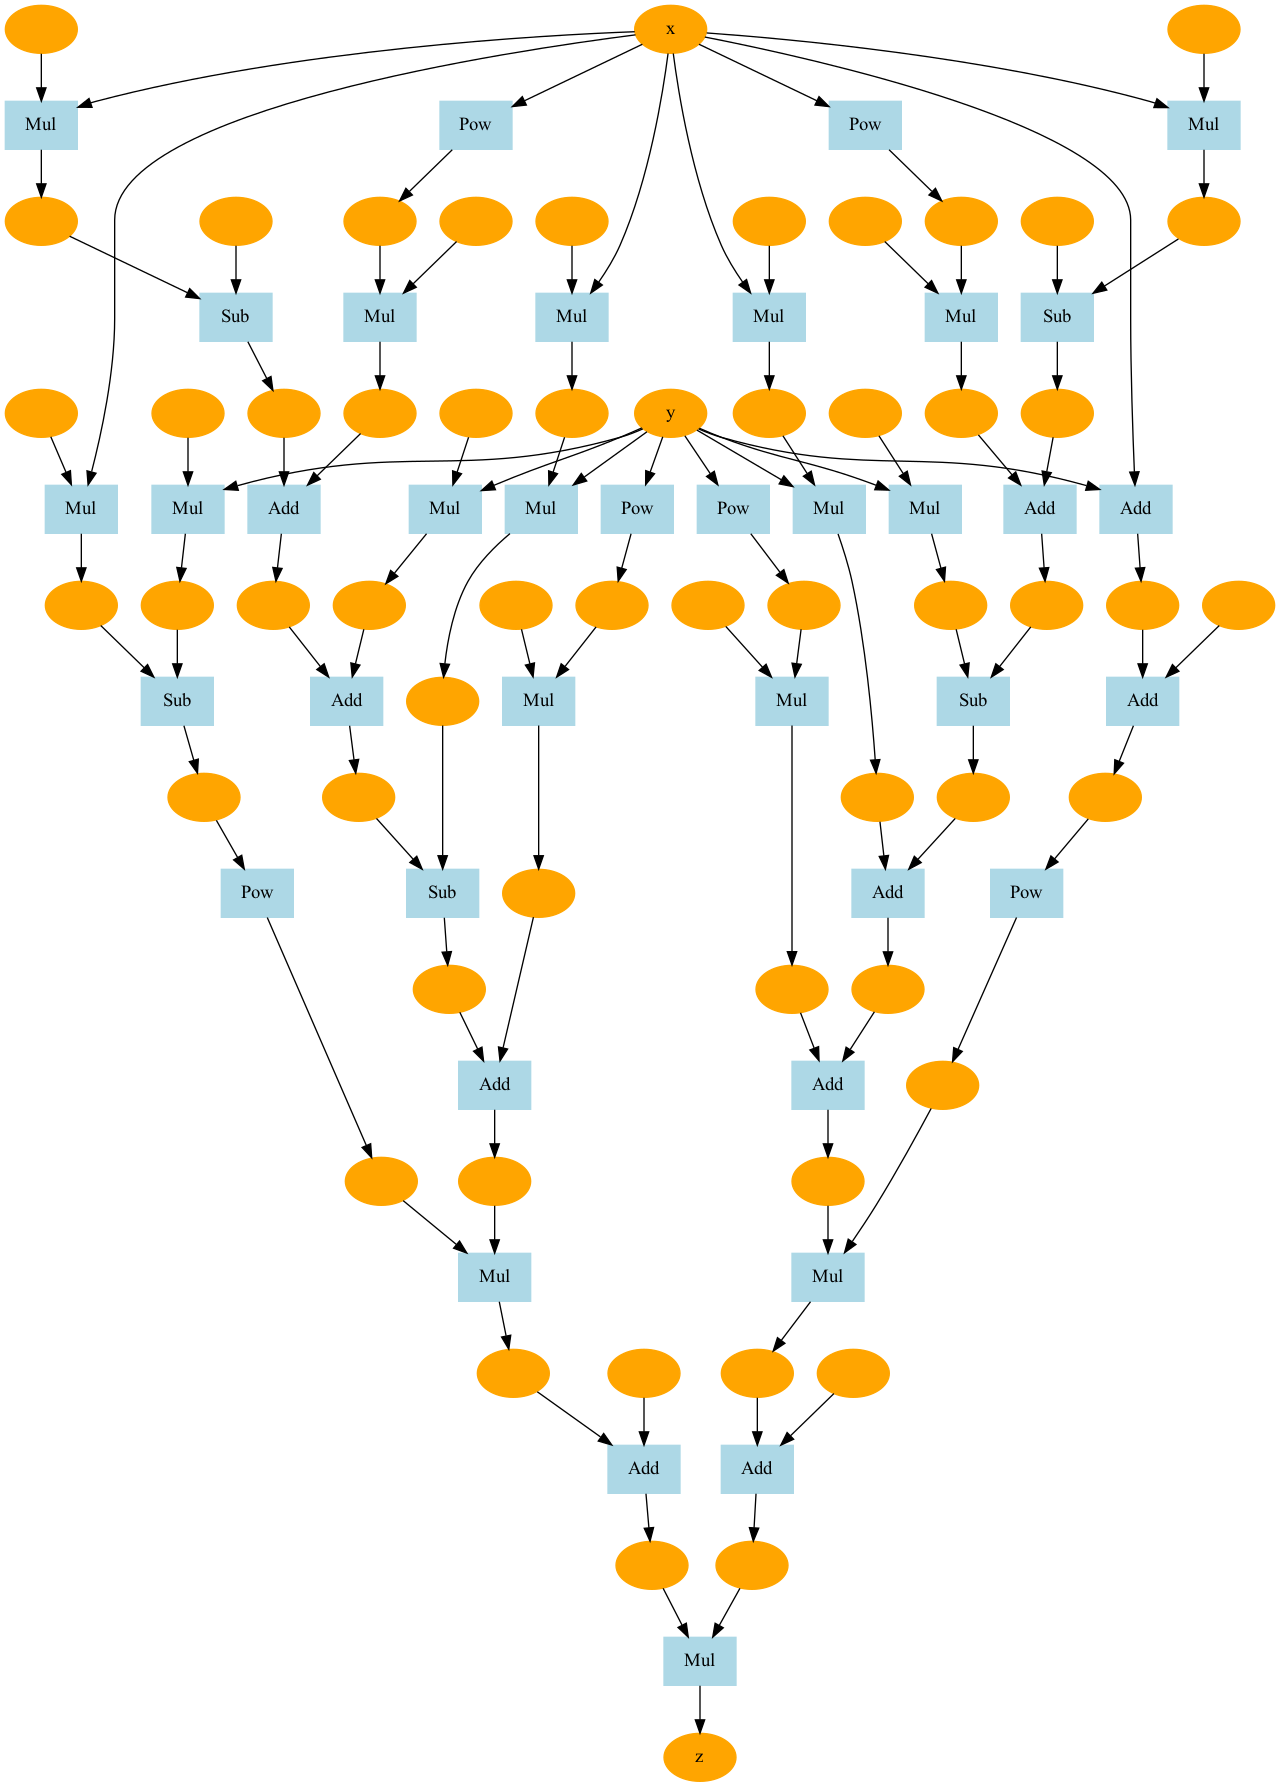

In [98]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph


def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

## ステップ２７　テイラー展開の微分＜１９７＞

テイラー展開を用いて多変数関数を微分していくことを考える

今回はsinに関してやっていく

そのためにsinクラスとsin関数を作る

In [99]:
import numpy as np
from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x):
    return Sin()(x)

$sin(\frac{\pi}{4})$を代入して計算してみる

In [100]:
x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
print(y.data)
print(x.grad)

--- original sin ---
0.7071067811865475
0.7071067811865476


では、テイラー展開して近似した結果との違いを見てみることにしよう

In [101]:
import math

def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

In [102]:
x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

--- approximate sin ---
0.7071064695751781
0.7071032148228457


この段階での計算グラフを出力してよう

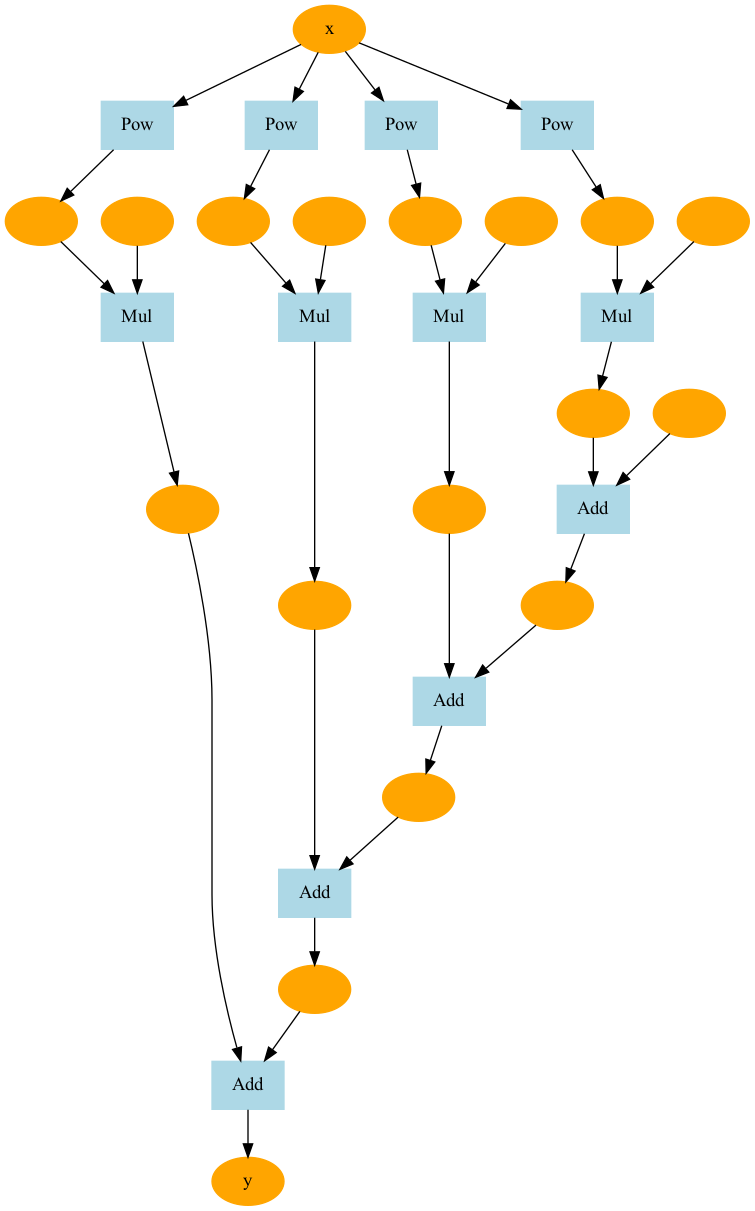

In [103]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin_threshould1e-4.png')

閾値をかなり小さく　1e-100とかにしてみたらどうなるのか確かめてみよう

--- approximate sin ---
0.7071067811865475
0.7071067811865475


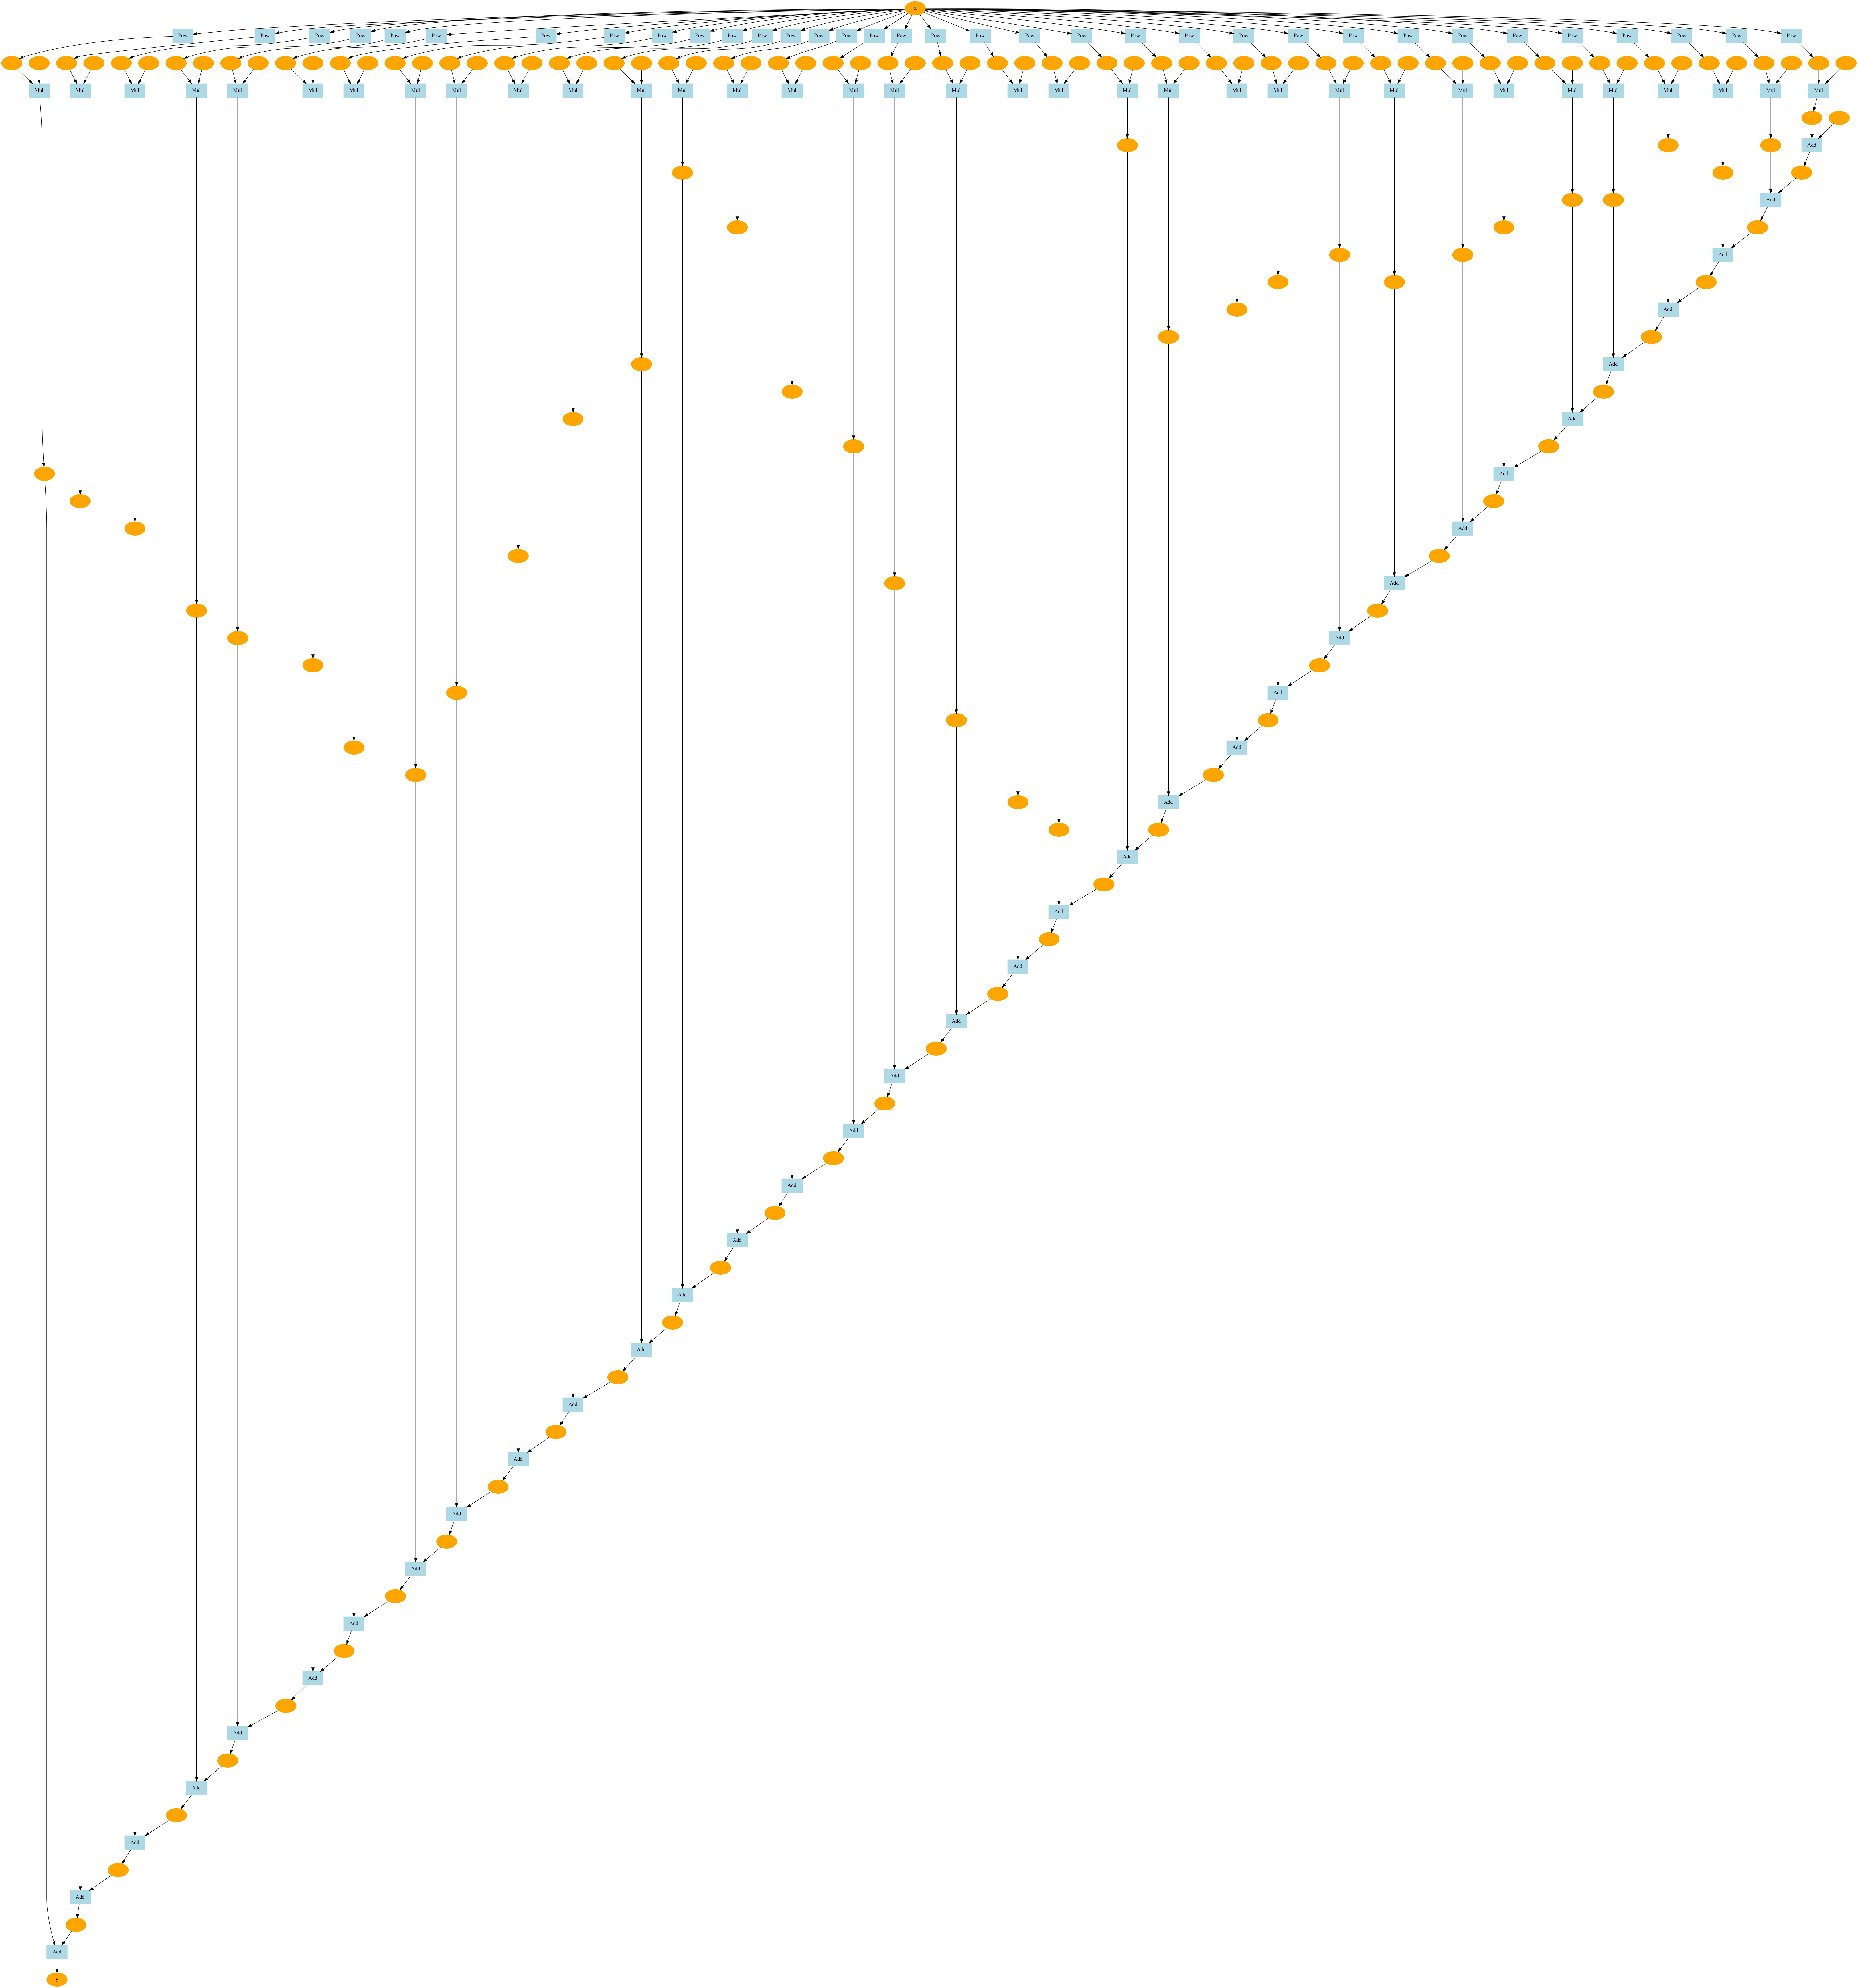

In [104]:
import math

def my_sin(x, threshold=1e-100):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin_threshould1e-100.png')

## ステップ２８　関数の最適化 <203>

ここでは関数の最適化をやっていく。

最適化ってアレな、関数の最大値or最小値をとる引数を探すっていうことな

NNも結局損失関数の出力を最小化する引数が知りたいわけだから、ここでの実装はそこにつながってくる。

では、具体的な関数に対して最適化を施していこうか

ローゼンブロック関数（バナナ関数）式省略をDeZeroを使って最小値を求めていこう

ちなみに先答え言っとくと(1, 1)だからね

じゃあまず手始めに(0,2)における微分を求めてみようか

In [105]:
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


この微分の結果をまとめたもの(ベクトルの形にしたものを)**勾配**って言います。

勾配は関数の出力を最も増やす方向を示してるので、逆に最小の値を求めたかったら、マイナスかければよろし

従ってyの値を最も減らす方向は(2, -400)とわかる。

ただ、これはこの関数自体の、最小ポイントかというとそういうわけじゃない

このポイント(0, 2)における最小の点であって、関数全体はここではない。

じゃあどうやれば関数全体になるかというと、この操作を繰り返してそうすると、勾配が更新されなくなって、最小の値にどんどん近づいていくはずだ。

では、こういう期待を込めた実装を**勾配降下法**という。

勾配降下法を実装していこう。

In [106]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 50000

for i in range(iters):
    print(x0, x1)
    
    y = rosenbrock(x0,x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

50000回も繰り返せばほぼ最小値に辿り着いたね！

## ステップ２9　ニュートン法を用いた最適化(手計算) <209>

勾配降下法よりも早く収束値に辿り着く方法はないだろうか

その一つに**ニュートン法**という有名な方法がある

先言っとくけど、この手計算って何かってニュートン法の更新に必要な２階微分のことだからね

それじゃ理論はテキスト参照で実装してこう

関数$y = x^{4} - 2x^{2}$を実装してこう

現状のDeZeroには２階微分が実装されてないのでそこを書かなあかんっていうところはある

In [107]:
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y


def gx2(x):
    return 12 * x ** 2 - 4


x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


ちなみに勾配降下法を使うと１２４回かかるから７回で最小値に辿り着くのはかなり早いね！

## ステップ３０　高階微分(準備編) <217>

さっきのニュートン法ってさ2階微分とかてけいさんで求めて実装したやんね

今回はそれすら自動化したいって言う気持ちを体現していこう

まぁこの章に関してはテキスト参照

## ステップ３1　高階微分(理論編) <225>

詳しくはテキスト

## ステップ３２　高階微分（実装編）＜２３１＞

詳しくはテキスト

## ステップ３３ ニュートン法を使った最適化（自動計算）

ここまでの実装を元に二回微分を計算させてみようか

$y = x^{4} + 2x^{2}$の二回微分を計算させてみよう

In [114]:
sys.path.append(os.path.join('/Users/ryushiro/Desktop/Dezero/dezero'))
import numpy as np
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)
print(type(y))
y.backward()
print(x.grad)
print(type(x.grad))

gx = x.grad
print(type(gx))
gx.backward(create_graph=True)
print(x.grad)

<class 'dezero.core_simple.Variable'>
24.0
<class 'numpy.float64'>
<class 'numpy.float64'>


AttributeError: 'numpy.float64' object has no attribute 'backward'

これさ、本当ならば、一回微分２４、二回びぶん４４

だから値間違ってるんだよね

どこが間違っているんだろうか

それは、Variableの値が残ったまま微分を続けてしまっている点がまずい。値が加算されていっちゃうからね

なので、一回微分の値リセットして、おかないと微分の値間違ってくる

In [ ]:
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)

ニュートン法による最適化も行っていこうか。

ニュートン法には二回微分が必要だが、これは今までの実装でできているはずだから、簡単にxの値を更新できるはずだ。

In [ ]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

## ステップ３4 sin関数の高階微分<241>

sin関数と、cos関数の実装は省略して実際に高階微分を動かすところから始めていこう

高階なんで、３、４回などの微分をやっていく感じね

In [ ]:
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

In [ ]:
import dezero.functions as F
import matplotlib.pyplot as plt

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data.flatten()]

for i in range(3):
    logs.append(x.grad.data.flatten())
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

#グラフの描画
labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i,v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

## ステップ３5 高階微分の計算グラフの可視化<247>

$(\mathrm{tanh}x )^{\prime} = 1 - y^{2}$っていうことを用いて

この計算グラフを可視化していこうと思う

そのためにまずは　tanhxを実装することから始めていこうか

ただ、この実装は省略する<２４９＞

計算グラフの可視化をおこなっていこう

In [ ]:
from dezero.utils import plot_dot_graph

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0

for i in range(iters):
    gx = x.grad
    x.cleargrad
    gx.backward(create_graph=True)

#計算グラフを描画
gx = x.grad
gx.name = 'gx' + str(iters + 1)
plot_dot_graph(gx, verbose=False, to_file='tanh1.png')

## ステップ３６　高階微分以外の用途<257>

backpropの高階微分に関しては今までのところで議論したので、ここでは高階微分以外の用途

具体的には、微分が含まれる式をさらに微分するという用途で見てみよう。

その例として、次の問題を考える

問:次式のx=2における$ \frac{\partial z}{\partial x} $を求めよ

$$y = x^{2},z = ( \frac{\partial y}{\partial x} )^{3} + y $$

ちなみに答えは１００

In [ ]:
x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()
print(gx)

z = gx ** 3 + y
z.backward()
print(x.grad)

# 第4ステージ　NNを作る

## ステップ３７　テンソルを扱う<269>

ここまで、入力や出力はスカラしか扱ってないが、結局ベクトルなどのテンソルじゃないと扱いにくいからね。

ただ、実は今回のDeZeroは今のままでもテンソルを扱えるんだ。

なんで買って、結局のところテンソルの各要素がスカラとして計算できてしまうから、テンソルであろうとスカラであろうと結果は変わんない。

## ステップ３８　形状を変える関数＜２７９＞

## ステップ４２　線形回帰<315>

ここからが機械学習をDezeroでやっていくみたいな話。

とりあえず、線形回帰をやっていく「。

そのために今回は、実験用の小さなデータセットであるトイデータセットっていうのを用意してやってみる

In [ ]:
if '__file__' in globals():
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
from dezero import Variable
import dezero.functions as F

#トイデータセットの作成
np.random.seed(0) #シード値固定で同じデータセットを作れるようにする
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros(1, 1))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

ここでは、とりあえずWはスカラーでした。

